# Importing the relevant libraries

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import torch.optim as optim

In [2]:
import pygad
import pygad.torchga as tga

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForImageClassification

In [4]:
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy

In [6]:
from sklearn.model_selection import train_test_split

# Model settings

Loading the device

In [7]:
device= torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device= 'cpu'
print('Current Device:', device)

Current Device: cuda:1


Assigning the output labels

In [8]:
building_labels= ['abandoned', 'commercial', 'industrial', 'others', 'religious', 'residential', 'underconstruction']

Loading the model

In [9]:
model=AutoModelForImageClassification.from_pretrained('facebook/dinov2-base-imagenet1k-1-layer', ignore_mismatched_sizes= True)
model.classifier= torch.nn.Linear(in_features= 1536, out_features= 7)
torch.cuda.empty_cache()
model.load_state_dict(torch.load('dinov2_phase1.pth'))
# model.load_state_dict(torch.load('dinov2_phase1.pth', map_location= device))


<All keys matched successfully>

Printing the model and its weights for confirmation

In [10]:
# for name, param in model.named_parameters():
#     print(name, ':', param.data)

In [11]:
# print(model)


Removing the final layer of the model and checking by printing the modified models and its weights

In [12]:
model.classifier= nn.Identity()

In [13]:
print(model)

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [14]:
# for name, param in model.named_parameters():
#     print(name, ':', param) 

Shifting model to device

In [15]:
model.to(device)
print('Model now on' ,device)

Model now on cuda:1


# Loading the single-type buildings dataset

## Class for loading the data

In [16]:
class LoadData(Dataset):
    def __init__(self, path, trf):
        self.path= path
        self.trf= trf

        self.labels= ['abandoned', 'commercial', 'industrial', 'others', 'religious', 'residential', 'underconstruction']
        self.data= self.load_data()

    #Function to load the path of the data and allocate it to test or train based on its name
    def load_data(self):   
        data= []
        for label_idx,label in enumerate(self.labels):
            loc= self.path+label+'/'

            for file in os.listdir(loc):
                    file_path= loc+file

                    data.append((file_path, label_idx)) 
        
        return data
    def __len__(self):
        return len(self.data)
    
    #Necessary for a DataLoader class, loads the image from the path and applies the suitable transformation
    def __getitem__(self,idx):
        img_path, label= self.data[idx]
        img= Image.open(img_path).convert('RGB')
        img= self.trf(img)
        return img, label

Applying transformation for uniformity

In [17]:
trf=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [18]:
path= '/DATA2/dse313/group10/pure/pure/'
single_type_dataset= LoadData(path, trf)

Creating the dataloader

In [19]:
single_loader= DataLoader(single_type_dataset, batch_size=32, shuffle= True)

# Functions to visualize representations on scatter plots

## Function for creating classwise representations

In [20]:
def get_classwise_representations(model, loader, device):

    model.eval()

    with torch.no_grad():
        
        classwise_rpns= {i:[] for  i in range(7)}
        for imgs, labels in loader:
            imgs= imgs.to(device)
            output= model(imgs)
            rpn= output.logits.cpu().numpy()
            for label in labels:
                # print(label)
                classwise_rpns[label.item()].append(rpn)
    
    return classwise_rpns

In [21]:
# classwise_rpns= get_classwise_representations(model, single_loader)

# for label, rpns in classwise_rpns.items():
#     classwise_rpns[label]= np.concatenate(rpns, axis= 0)
    
# np.save('classwise_rpns.npy', classwise_rpns)


## Function for creating PCA scatter plot

In [22]:
def create_pca_scatter(classwise_rpns, building_labels):

    plt.figure()
    centroids_pca= dict()
    for idx, rpn in classwise_rpns.items():
        pca= PCA(n_components=2)
        pca_rpn= pca.fit_transform(rpn)
        centroid= np.mean(pca_rpn, axis= 0)
        centroids_pca[idx]= centroid
        # plt.scatter(pca_rpn[:, 0], pca_rpn[:, 1], label= building_labels[idx], alpha= 0.1)
        plt.scatter(centroid[0], centroid[1], label= building_labels[idx])

    plt.title('PCA centroids of all the classes')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend(loc= 'lower center', ncol= 4, bbox_to_anchor= (0.5,-0.35))
    plt.tight_layout()
    plt.show()

    return centroids_pca

In [ ]:
# centroids_pca= create_pca_scatter(classwise_rpns, building_labels)

## Function for creating t-SNE scatter plot

In [24]:
def create_tsne_scatter(classwise_rpns, building_labels):

    plt.figure()
    centroids_tsne= dict()
    for idx, rpn in classwise_rpns.items():
        tsne= TSNE(n_components= 2)
        tsne_rpn= tsne.fit_transform(rpn)
        centroid= np.mean(tsne_rpn, axis= 0)
        centroids_tsne[idx]= centroid
        # plt.scatter(tsne_rpn[:, 0], tsne_rpn[:, 1], label= building_labels[idx])
        plt.scatter(centroid[0], centroid[1], label= building_labels[idx])

    plt.title('TSNE centroids of all the classes')
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.legend(loc= 'lower center', ncol= 4, bbox_to_anchor= (0.5,-0.35))
    plt.tight_layout()
    plt.show()
    
    return centroids_tsne

In [25]:
# centroids_tsne= create_tsne_scatter(classwise_rpns, building_labels)

Saving the centroid dictionaries for later, faster reference

In [26]:
# np.save('centroids_pca.npy', centroids_pca)
# np.save('centroids_tsne.npy', centroids_tsne)

In [27]:
# check= np.load('centroids_pca.npy', allow_pickle= True).item()

# Triplet Loss functions

## Creating triplets of single type image data

Class for loading the dataset in triplet form. Positive is chosen randomly from the same class as that of anchor. Negsative is chosen randomly from a different class as that of Anchor

In [28]:
class LoadData_Triplet(Dataset):
    def __init__(self, path, trf):
        self.path= path
        self.trf= trf

        self.labels= ['abandoned', 'commercial', 'industrial', 'others', 'religious', 'residential', 'underconstruction']
        self.data= self.load_data()

    #Function to load the path of the data and allocate it to test or train based on its name
    def load_data(self):   
        data= []
        for label_idx,label in enumerate(self.labels):
            loc= self.path+label+'/'

            for file in os.listdir(loc):
                    file_path= loc+file

                    data.append((file_path, label_idx)) 
        
        return data
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        
        anchor_img_path, anchor_label= self.data[idx]
        anchor_img= Image.open(anchor_img_path).convert('RGB')
        anchor_img= self.trf(anchor_img)
        
        #Positive Class
        positive_data= [item for item in self.data if item[1]==anchor_label and item[0]!= anchor_img_path]
        positive_img_path, _= random.choice(positive_data)
        positive_img= Image.open(positive_img_path).convert('RGB')
        positive_img= self.trf(positive_img)
        
        #Negative Class
        negative_data= [item for item in self.data if item[1]!=anchor_label]
        negative_img_path, _= random.choice(negative_data)
        negative_img= Image.open(negative_img_path).convert('RGB')
        negative_img= self.trf(negative_img)
        
        return anchor_img, positive_img, negative_img, anchor_label

In [29]:
trf= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [30]:
path= '/DATA2/dse313/group10/pure/pure/'
triplet_dataset= LoadData_Triplet(path, trf)

In [31]:
train_split, val_split= train_test_split(triplet_dataset, test_size= 0.25, random_state= 2)

In [32]:
train_loader= DataLoader(train_split, batch_size= 32, shuffle= True)
val_loader= DataLoader(val_split, batch_size= 32, shuffle= True)

## Visualizing random triplets

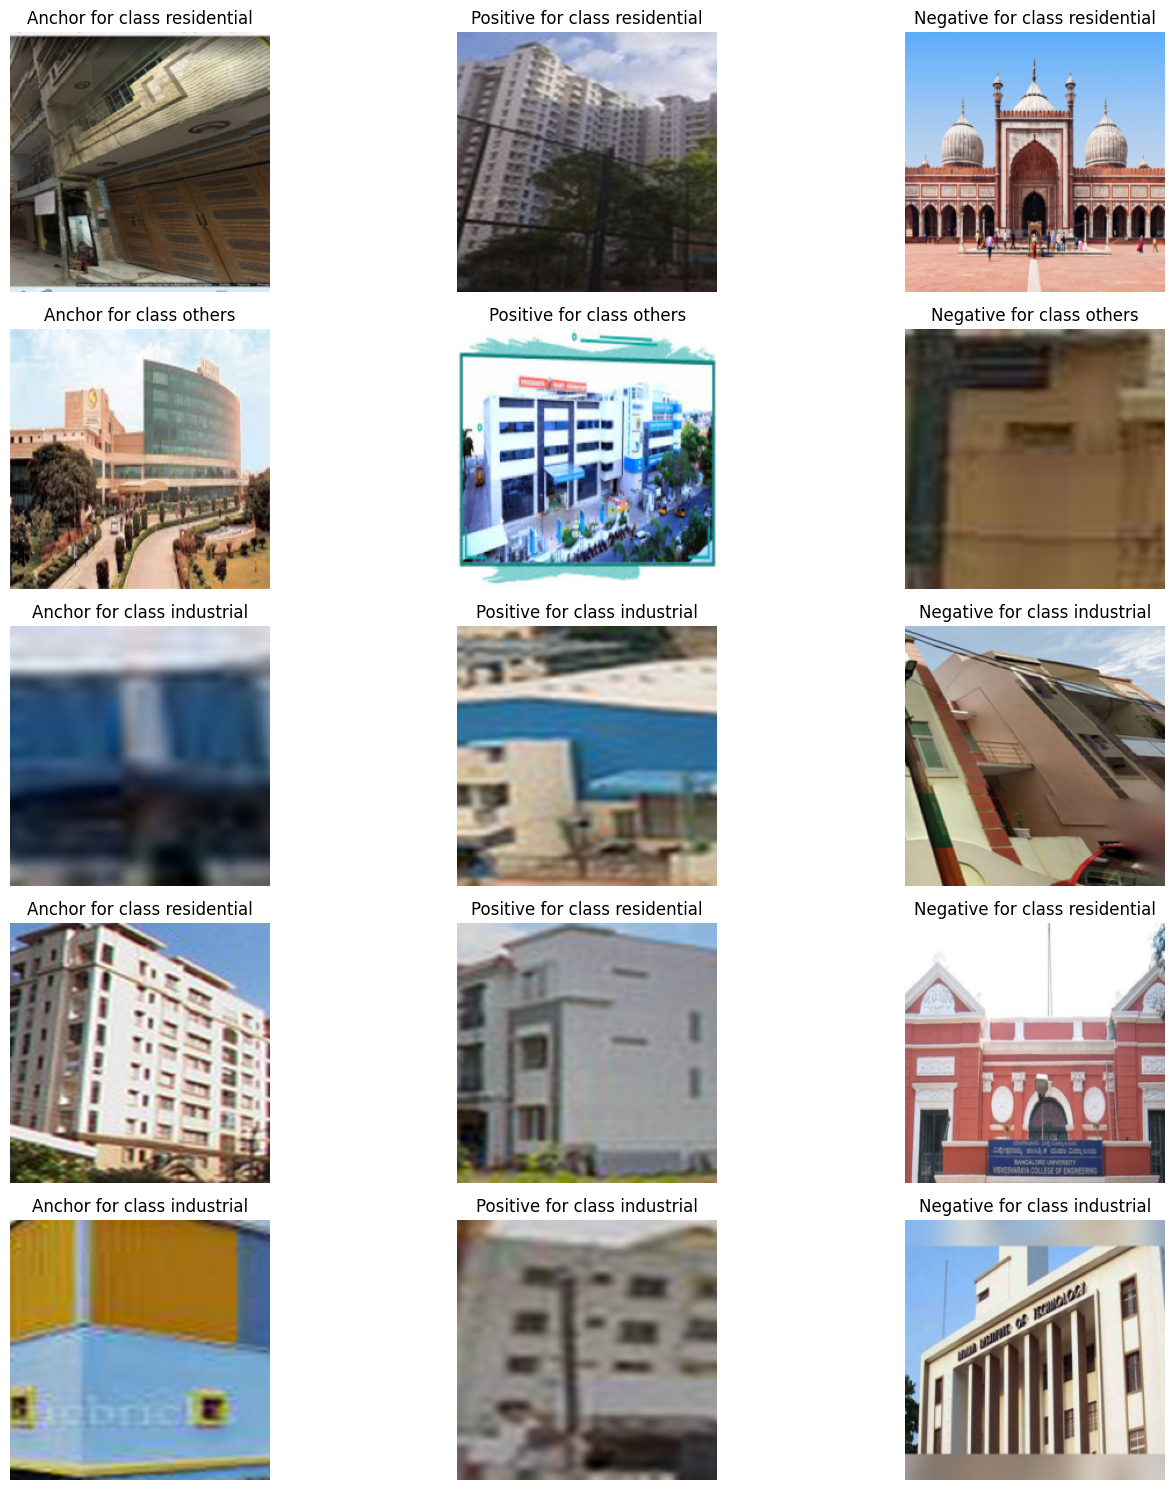

In [33]:
fig, ax= plt.subplots(nrows=5, ncols=3, figsize=[15,15])

c=0
for i in range(5):
    idx= random.randint(0,len(triplet_dataset)-1)
    anchor, positive, negative, label= triplet_dataset[idx]
    
    for x in [anchor, positive, negative]:
        axi=ax.flat[c]
        axi.imshow(transforms.ToPILImage()(x))
        
        if x is anchor: y='Anchor'
        if x is positive: y='Positive'
        if x is negative: y='Negative'
        
        axi.set_title(f'{y} for class {building_labels[label]}')
        axi.axis('off')
        c+=1

plt.tight_layout()
plt.show()

## Triplet Loss Function

In [34]:
class TripletLoss(nn.Module):
    def __init__(self, margin= 1.0):
        super(TripletLoss, self).__init__()
        self.margin= margin
        

    def forward(self, anchor, positive, negative):
        distance_positive= torch.norm(anchor-positive, dim=1)
        distance_negative= torch.norm(anchor-negative, dim=1)
        loss= torch.relu(distance_positive-distance_negative+self.margin)
        return loss.mean()


# Training the model with MLP addons on triplets loss

Freezing the base model

In [35]:
for param in model.parameters():
    param.requires_grad= False

In [36]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

## Codes for training and loss curves

In [37]:
def train_model(model, train_loader, val_loader, epochs, device): 
    
    train_losses= []
    val_losses= []
    optimizer= optim.Adam(params=model.parameters(), lr= 5e-4)
    loss_fun= TripletLoss(margin= 1)
    model.to(device)
    
    for epoch in tqdm(range(epochs), desc='Epochs'):
        
        #Training
        tot_train_loss= 0
        model.train()
        
        tick= time.time()
        
        for batch_id, (anchor, positive, negative, _) in enumerate(tqdm(train_loader, desc='Training', leave= False)):
            anchor= anchor.to(device)
            positive= positive.to(device)
            negative= negative.to(device)
            optimizer.zero_grad()
            
            anchor_out= model(anchor)
            positive_out= model(positive)
            negative_out= model(negative)
            
            loss= loss_fun(anchor_out.logits, positive_out.logits, negative_out.logits)
            loss.backward()
            optimizer.step()
            
            tot_train_loss+= loss.item()*anchor.size(0)
        train_loss= tot_train_loss/len(train_loader.dataset)
        train_losses.append(train_loss)
        
        #Validation
        tot_val_loss= 0
        model.eval()
        with torch.no_grad():
            for batch_id, (anchor, positive, negative, _) in enumerate(tqdm(val_loader, desc='Validation', leave= False)):
                anchor= anchor.to(device)
                positive= positive.to(device)
                negative= negative.to(device)
                
                anchor_out= model(anchor)
                positive_out= model(positive)
                negative_out= model(negative)
                
                loss= loss_fun(anchor_out.logits, positive_out.logits, negative_out.logits)
                tot_val_loss+= loss.item()*anchor.size(0)
        val_loss= tot_val_loss/len(val_loader.dataset)
        val_losses.append(val_loss)
        
        tock= time.time()
        print('Epoch: {}/{}  -  Train Loss: {:.4f}  -  Val Loss: {:.4f}  -  Time: {:.2f} seconds'.format(epoch+1, epochs, train_loss, val_loss, (tock-tick)))
            
    return train_losses, val_losses
            


In [38]:
def plot_curves(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training model with 0 hidden layers

### Adding the MLP layer

In [39]:
# addon0 = nn.Sequential(
#     nn.Linear(1536, 256))   # Considering 256-D output

In [40]:
# model0= copy.deepcopy(model)
# model0.classifier= addon0

In [41]:
# for name, param in model0.classifier.named_parameters():
#     param.requires_grad= True

### Sanity Checking

In [42]:
# for name, param in model0.named_parameters():
#     if param.requires_grad:
#         print(name)

In [43]:
# print(model0)

### Training the model

In [44]:
# epochs= 15

In [45]:
# train_losses, val_losses= train_model(model0, train_loader, val_loader, epochs= epochs, device= device)

In [46]:
# plot_curves(train_losses, val_losses)

## Training the model with 1 hidden layer

### Adding the MLP Layer

In [47]:
# addon1 = nn.Sequential(
#     nn.Linear(1536, 384),   
#     nn.ReLU(),
#     nn.Dropout(p= 0.25),
#     nn.Linear(384, 96))

In [48]:
# model1= copy.deepcopy(model)
# model1.classifier= addon1

In [49]:
# for name, param in model1.classifier.named_parameters():
#     param.requires_grad= True

### Sanity checking

In [50]:
# for name, param in model1.named_parameters():
#     if param.requires_grad:
#         print(name)

In [51]:
# print(model1)

### Training the model

In [52]:
# epochs= 6

In [53]:
# train_losses, val_losses= train_model(model1, train_loader, val_loader, epochs= epochs, device= device)

In [54]:
# plot_curves(train_losses, val_losses)

## Training the model with 2 hidden layers

### Adding the MLP Layer

In [55]:
addon2 = nn.Sequential(
    nn.Linear(1536, 256),
    nn.GELU(),
    nn.Dropout(p= 0.25),
    
    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(p= 0.25),
    
    nn.Linear(128, 64))

In [56]:
model2= copy.deepcopy(model)
model2.classifier= addon2

### Sanity Checking

In [57]:
for name, param in model2.classifier.named_parameters():
    param.requires_grad= True

In [58]:
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [59]:
# print(model2)

### Training the model

In [60]:
epochs= 8

In [61]:
# train_losses, val_losses= train_model(model2, train_loader, val_loader, epochs= epochs, device= device)

In [62]:
# plot_curves(train_losses, val_losses)

## Selecting and training the final model

Based on all the runs, the best model was selected as a model with 2 hidden layers, GELU activation, Dropout of 0.25 between the layers

In [63]:
final_addon = nn.Sequential(
    nn.Linear(1536, 256),
    nn.GELU(),
    nn.Dropout(p= 0.25),
    
    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(p= 0.25),
    
    nn.Linear(128, 64))

model_nn_final= copy.deepcopy(model2)

In [64]:
for param in model2.parameters():
    param.requires_grad= False

In [65]:
# torch.save(model_nn_final.state_dict(), 'model_nn_final.pth')

In [66]:
model_nn_final.load_state_dict(torch.load('model_nn_final.pth'))

<All keys matched successfully>

In [67]:
print(model_nn_final)
for name, param in model_nn_final.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter values: {param}")



Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [68]:
for name, param in model_nn_final.classifier.named_parameters():
    print(f"Classifier Parameter name: {name}")
    print(f"Classifier Parameter values: {param}")

Classifier Parameter name: 0.weight
Classifier Parameter values: Parameter containing:
tensor([[ 0.0077,  0.0177,  0.0158,  ...,  0.0286,  0.0073,  0.0175],
        [-0.0409,  0.0216, -0.0158,  ..., -0.0513,  0.0179, -0.0113],
        [-0.0277, -0.0151, -0.0162,  ...,  0.0090,  0.0029, -0.0102],
        ...,
        [-0.0262,  0.0150,  0.0061,  ...,  0.0105,  0.0213, -0.0192],
        [-0.0085,  0.0073, -0.0062,  ...,  0.0153,  0.0021,  0.0015],
        [ 0.0062,  0.0101,  0.0178,  ...,  0.0056, -0.0142,  0.0007]],
       requires_grad=True)
Classifier Parameter name: 0.bias
Classifier Parameter values: Parameter containing:
tensor([-0.0321, -0.0020,  0.0005,  0.0174, -0.0119,  0.0154,  0.0138, -0.0067,
        -0.0217,  0.0248, -0.0190, -0.0105,  0.0182, -0.0230, -0.0198,  0.0109,
        -0.0124, -0.0122,  0.0136,  0.0184,  0.0211, -0.0120, -0.0316, -0.0041,
         0.0124, -0.0149, -0.0170, -0.0140,  0.0007, -0.0045,  0.0013, -0.0107,
         0.0136, -0.0245,  0.0184,  0.0032, -0.

In [69]:
print(model_nn_final.classifier.named_parameters())

<generator object Module.named_parameters at 0x7f76c08340b0>


# Analysing and selecting the best weights using this neural network

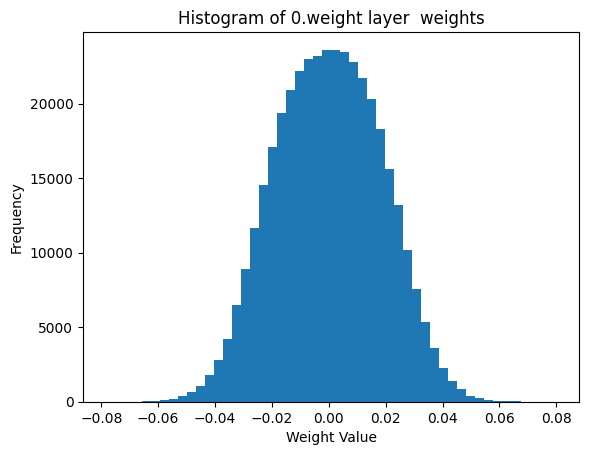

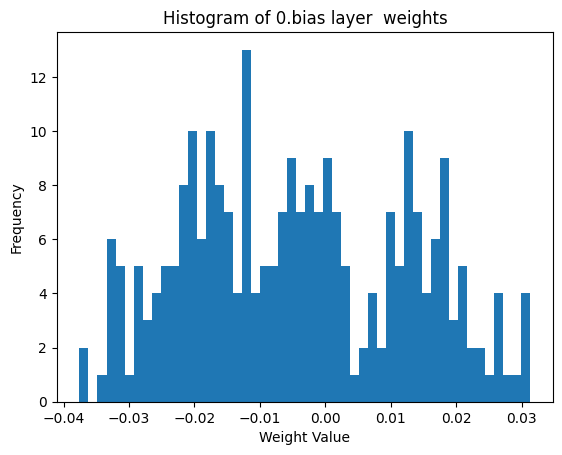

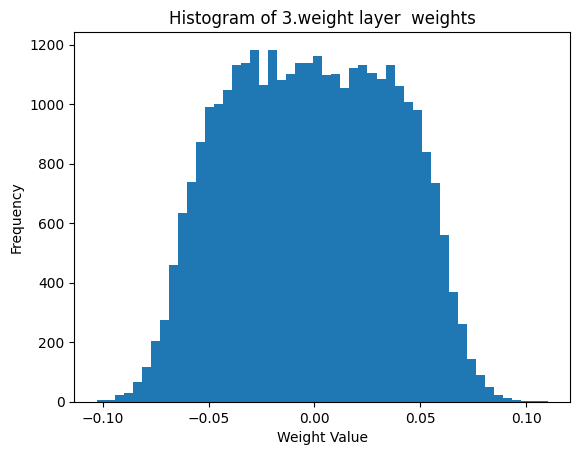

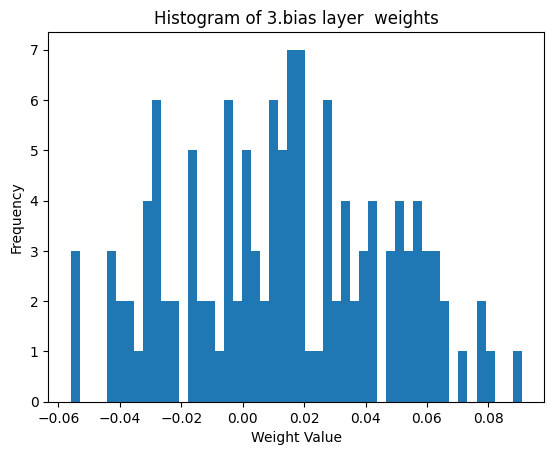

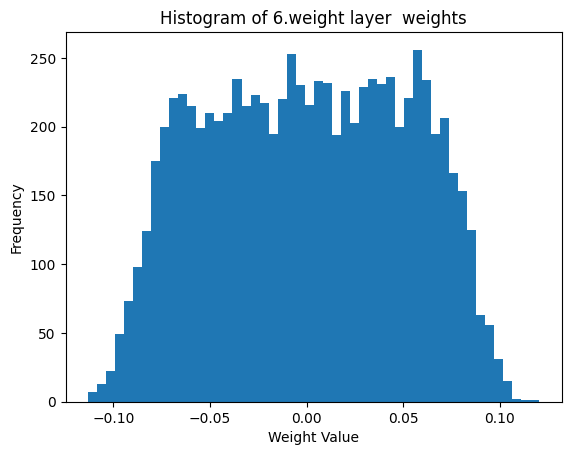

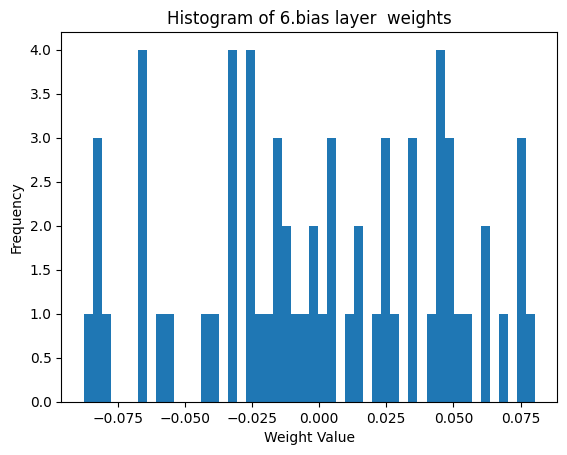

In [70]:
for name, param in model_nn_final.classifier.named_parameters():
    weights = param.data

    # Visualize weights (example)
    plt.figure()
    plt.hist(weights.cpu().numpy().flatten(), bins=50)
    plt.title(f'Histogram of {name} layer  weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

# Applying Genetic Algorithm to get the best weights

In [71]:
final_layer_wts = model_nn_final.classifier[6].parameters()

final_layer_wts_list = list(final_layer_wts)
for param in final_layer_wts_list:
    print(param.data)


tensor([[-0.0758,  0.0132,  0.0767,  ..., -0.0061, -0.0039, -0.0371],
        [ 0.0677, -0.0676, -0.0857,  ..., -0.0872, -0.0444,  0.0133],
        [ 0.0509,  0.0278,  0.0149,  ..., -0.0923,  0.0723, -0.0777],
        ...,
        [ 0.0081,  0.0839, -0.0320,  ...,  0.0562,  0.0956, -0.0083],
        [ 0.0743,  0.0078,  0.0589,  ..., -0.0061, -0.0669, -0.0175],
        [-0.0165,  0.0355,  0.0057,  ..., -0.0345, -0.0156,  0.0764]])
tensor([-0.0813,  0.0500,  0.0616,  0.0490, -0.0129, -0.0247,  0.0032,  0.0333,
        -0.0835,  0.0526,  0.0153,  0.0615, -0.0373,  0.0216,  0.0262,  0.0696,
         0.0152, -0.0788, -0.0427, -0.0193, -0.0643, -0.0876,  0.0354, -0.0833,
        -0.0651,  0.0344, -0.0153, -0.0029,  0.0051, -0.0307, -0.0102,  0.0426,
         0.0441, -0.0244, -0.0271, -0.0031, -0.0566, -0.0236, -0.0658, -0.0309,
        -0.0320,  0.0024, -0.0666,  0.0120, -0.0328,  0.0453,  0.0241,  0.0039,
         0.0471, -0.0600,  0.0739,  0.0272, -0.0268,  0.0739,  0.0434, -0.0050,
      

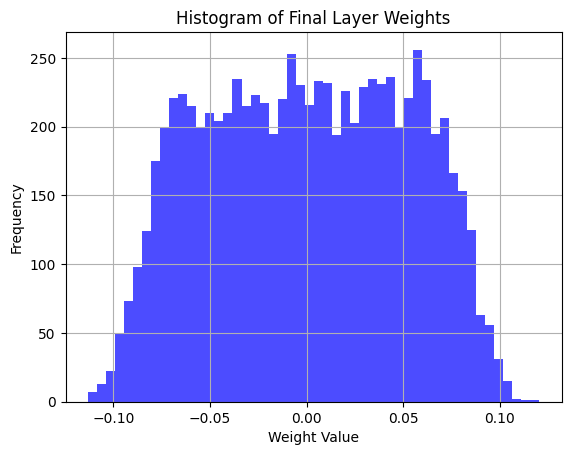

Bin 1: Range: (-0.113101386, -0.10842982), Frequency: 7
Bin 2: Range: (-0.10842982, -0.103758246), Frequency: 13
Bin 3: Range: (-0.103758246, -0.09908668), Frequency: 22
Bin 4: Range: (-0.09908668, -0.09441511), Frequency: 49
Bin 5: Range: (-0.09441511, -0.08974355), Frequency: 73
Bin 6: Range: (-0.08974355, -0.08507197), Frequency: 98
Bin 7: Range: (-0.08507197, -0.08040041), Frequency: 124
Bin 8: Range: (-0.08040041, -0.07572884), Frequency: 175
Bin 9: Range: (-0.07572884, -0.07105727), Frequency: 200
Bin 10: Range: (-0.07105727, -0.0663857), Frequency: 221
Bin 11: Range: (-0.0663857, -0.061714135), Frequency: 224
Bin 12: Range: (-0.061714135, -0.057042565), Frequency: 215
Bin 13: Range: (-0.057042565, -0.052371), Frequency: 199
Bin 14: Range: (-0.052371, -0.04769943), Frequency: 210
Bin 15: Range: (-0.04769943, -0.043027863), Frequency: 204
Bin 16: Range: (-0.043027863, -0.038356293), Frequency: 210
Bin 17: Range: (-0.038356293, -0.033684723), Frequency: 235
Bin 18: Range: (-0.03368

In [72]:
# Extracting final layer weights
final_layer_wts = model_nn_final.classifier[6].weight.data.cpu().numpy()

# Plotting Histogram
hist, bin_edges = np.histogram(final_layer_wts.flatten(), bins=50)

plt.hist(final_layer_wts.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Final Layer Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

for i in range(len(hist)):
    bin_range = (bin_edges[i], bin_edges[i+1])
    print(f"Bin {i+1}: Range: {bin_range}, Frequency: {hist[i]}")


## Reducing the number of Bins to 4. (These will be the number of genes to find our best suited weights)

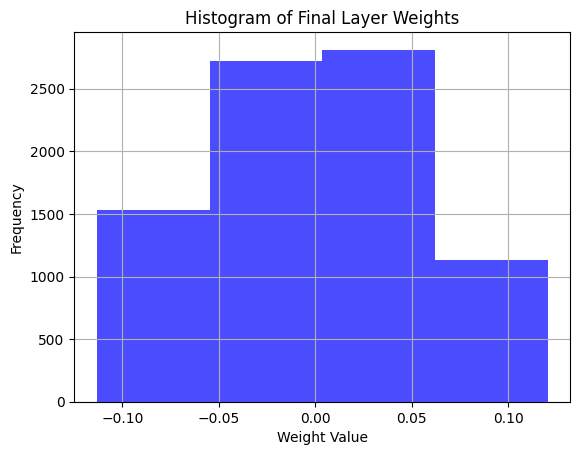

Bin 1: Range: (-0.113101386, -0.054706782), Frequency: 1528
Bin 2: Range: (-0.054706782, 0.0036878213), Frequency: 2720
Bin 3: Range: (0.0036878213, 0.062082425), Frequency: 2812
Bin 4: Range: (0.062082425, 0.12047703), Frequency: 1132


In [73]:
# Extracting final layer weights
final_layer_wts = model_nn_final.classifier[6].weight.data.cpu().numpy()
hist, bin_edges = np.histogram(final_layer_wts.flatten(), bins=4)

plt.hist(final_layer_wts.flatten(), bins=4, alpha=0.7, color='blue')
plt.title('Histogram of Final Layer Weights')
plt.xlabel('Weight Value')

plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Printing frequencies associated with each bin along with bin range
for i in range(len(hist)):
    bin_range = (bin_edges[i], bin_edges[i+1])
    print(f"Bin {i+1}: Range: {bin_range}, Frequency: {hist[i]}")

In [74]:
# Calculate middle value of each bin range
a = (bin_edges[0] + bin_edges[1]) / 2
b = (bin_edges[1] + bin_edges[2]) / 2
c = (bin_edges[2] + bin_edges[3]) / 2
d = (bin_edges[3] + bin_edges[4]) / 2


print("a:", a)
print("b:", b)
print("c:", c)
print("d:", d)


a: -0.08390408754348755
b: -0.025509480386972427
c: 0.032885123044252396
d: 0.09127973020076752


These shall be our 4 genes. We shall now have a genome size of 64 with randomised genes. Genetic Algorithm will run on combinations of 8 parents until population size 20 is reached. After that only the best 20 are allowed to survive and populate again. These best 20 are are decided upon being tested for giving the best results for Triplet Loss. Mutation rate is taken to be ___. The best gene is taken for weight matrix after a round of 100 generations(iterations).

In [75]:
last_4_layer_params= list(model_nn_final.classifier.parameters())

initial_weights= []
for param in last_4_layer_params:
    initial_weights.append(param.detach().numpy())
    
# print(initial_weights)
print(len(initial_weights[4]))
print(initial_weights[4])

64
[[-0.07583536  0.01318825  0.07670711 ... -0.0060617  -0.00387682
  -0.0371035 ]
 [ 0.06768046 -0.06759465 -0.08571009 ... -0.08717526 -0.0443914
   0.01333067]
 [ 0.05085584  0.02781186  0.01491298 ... -0.09226426  0.07227177
  -0.07765185]
 ...
 [ 0.00813881  0.08386207 -0.03199837 ...  0.05621874  0.0956289
  -0.00827696]
 [ 0.07428358  0.0078347   0.05892253 ... -0.00612005 -0.06689423
  -0.0175071 ]
 [-0.01649737  0.03548014  0.00573307 ... -0.03447839 -0.01564511
   0.07638346]]


In [76]:

num_solutions = 6

# Generating 6 random arrays of length 8256 with elements from the specified values:
values = np.array([-0.08390408754348755, -0.025509480386972427, 0.032885123044252396, 0.09127973020076752])
initial_population = [np.random.choice(values, size=8256) for _ in range(num_solutions)]

torch_ga = tga.TorchGA(model=model_nn_final.classifier[6], num_solutions=num_solutions)
torch_ga.population_weights = initial_population

print(torch_ga.population_weights)

[array([-0.02550948, -0.02550948,  0.09127973, ...,  0.09127973,
       -0.08390409,  0.09127973]), array([ 0.09127973,  0.09127973, -0.02550948, ...,  0.09127973,
        0.03288512,  0.09127973]), array([-0.02550948,  0.09127973, -0.08390409, ..., -0.08390409,
        0.09127973, -0.08390409]), array([-0.08390409, -0.02550948,  0.03288512, ..., -0.08390409,
        0.03288512,  0.09127973]), array([-0.02550948, -0.08390409, -0.08390409, ...,  0.03288512,
        0.09127973, -0.08390409]), array([-0.02550948,  0.03288512,  0.03288512, ..., -0.02550948,
        0.03288512, -0.02550948])]


The above hence is our Initial Population of 6 Genomes.

## Sanity Checking

In [77]:
for arr in initial_population:
    print(len(arr))

8256
8256
8256
8256
8256
8256


Defined the fitness function: This function took the solution (array of weights) as input, replaced the weights of the last layer in the classifier with the provided solution, and then calculated the triplet loss over the validation dataset using the modified model.
Defined the genetic algorithm parameters: Set up the genetic algorithm with appropriate parameters such as the number of generations, population size, mutation rate, and crossover method.
Ran the genetic algorithm: Executed the genetic algorithm, where each solution in the population represents a set of weights for the last layer of the classifier.
Got the best solutions: Retrieved the best solutions (arrays of weights) obtained from the genetic algorithm.

In [80]:
device = torch.device("cuda:1")
model_nn_final.to(device) 

val_dataset = val_loader.dataset

In [82]:
device = torch.device("cuda:1")
model_nn_final.to(device)
val_dataset = val_loader.dataset
embeddings= []

for sample in val_dataset:
    input_data = sample[0] 
    input_data = input_data.unsqueeze(0)
    input_data = input_data.to(device)
    output = model_nn_final(input_data)
    embedding = output.logits.detach().cpu().numpy()  
    embeddings.append(embedding) 
    
predictions = np.array(embeddings)


In [83]:
print(input_data.shape)
print(output.logits.shape)
print(embedding.shape)
print(predictions.shape)


torch.Size([1, 3, 224, 224])
torch.Size([1, 64])
(1, 64)
(943, 1, 64)


In [84]:
print("Predictions:", predictions)

Predictions: [[[ 0.4449894  -0.27174976  0.5932522  ...  0.82083327  0.34270903
    0.02047517]]

 [[ 0.75391364  0.3433427   0.75913966 ... -0.06175371  0.5778182
   -0.45757872]]

 [[-0.09594236 -0.01428743  0.1844517  ...  0.61134326  0.40810326
   -0.14485472]]

 ...

 [[ 0.33609173 -0.03044431  0.37232614 ... -0.88727295  0.70920914
   -0.5509214 ]]

 [[ 1.1709604   0.09627035  0.31834555 ... -1.436133    0.23801826
   -1.0813941 ]]

 [[ 0.07673648  2.089201   -1.2093661  ... -0.5432958  -1.267159
    0.34603596]]]


Getting the output of the GA weights on the validation set images

In [85]:
# data_outputs = []

# val_dataset = val_loader.dataset

# for epoch in tqdm(range(epochs), desc='Epochs'):
#     # Training and validation loops

#     for batch_id, (anchor, positive, negative, _) in enumerate(tqdm(val_loader, desc='Training', leave=False)):
#         # Training loop
#         anchor_out = model(anchor.to(device))
#         positive_out = model(positive.to(device))
#         negative_out = model(negative.to(device))
        
#         # Concatenate the embeddings for the current batch
#         batch_outputs = torch.cat((anchor_out.logits, positive_out.logits, negative_out.logits), dim=1)
#         data_outputs.append(batch_outputs.detach().cpu().numpy())

# data_outputs = np.concatenate(data_outputs, axis=0)


In [86]:
# np.save('data_outputs.npy', data_outputs)


In [87]:
data_outputs= np.load('data_outputs.npy')

In [88]:
print("Data Outputs:", data_outputs)

Data Outputs: [[ 0.22340514 -0.20567943 -0.16954319 ... -0.44794524 -0.37802273
  -1.6254768 ]
 [ 1.0855504  -1.1306742   1.1364686  ... -0.20135562  0.5143995
  -0.69497186]
 [ 0.06959864  0.22453363  0.11346139 ...  0.1647281  -0.83936834
   0.22609858]
 ...
 [-1.4604756   0.67524123 -0.16170728 ... -1.0066375   0.79619896
  -0.97499245]
 [-1.9106479  -2.1919067  -0.94440657 ... -0.70529824 -0.49864763
  -1.2477148 ]
 [-1.1352249  -1.5284657   0.9492867  ... -0.62502563 -0.360253
  -1.4727204 ]]


In [89]:
anchor_out = model_nn_final(anchor.unsqueeze(0).to(device))
positive_out = model_nn_final(positive.unsqueeze(0).to(device))
negative_out = model_nn_final(negative.unsqueeze(0).to(device))

In [90]:

anchor_pred_tensor = (anchor_out.logits)
positive_pred_tensor = (positive_out.logits)
negative_pred_tensor = (negative_out.logits)

loss_function = torch.nn.TripletMarginLoss()
loss = loss_function(anchor_pred_tensor, positive_pred_tensor, negative_pred_tensor)


Defining the fitness function as the inverse of the triplet loss value

In [92]:
fitness_value = (1.0 / (loss + 0.00000001))

In [93]:
loss_function = nn.TripletMarginLoss()

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    model_weights_dict = tga.model_weights_as_dict(model=model,
                                                         weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    predictions = model(data_inputs)

    solution_fitness = 1.0 / (loss_function(predictions, data_outputs).detach().numpy() + 0.00000001)

    return solution_fitness

In [94]:
loss_function = torch.nn.L1Loss()

def fitness_func(inst, solution, solution_idx):
    solution= solution[:8192]
    weights = np.array(solution).reshape((64, 128))  # Assuming the last layer size is 128*64
    loss_fun = TripletLoss(margin=1)

    with torch.no_grad():
        model_nn_final.classifier[6].weight.data = torch.tensor(weights, dtype=torch.float32)

    # Calculate Triplet Loss on validation set
    model_nn_final.to(device)
    val_losses = []
    model_nn_final.eval()
    with torch.no_grad():
        for anchor, positive, negative, _ in val_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_out = model_nn_final(anchor)
            positive_out = model_nn_final(positive)
            negative_out = model_nn_final(negative)

            loss = loss_fun(anchor_out.logits, positive_out.logits, negative_out.logits)
            val_losses.append(loss.item())

    # Return negative mean of validation losses as fitness value
    return -np.mean(val_losses)

In [95]:
def parent_selection(fitness, num_parents, ga_instance):
    selected_parents_indices = pygad.tournament_selection(fitness, num_parents=num_parents, tournament_size=3)
    return ga_instance.population[selected_parents_indices]

def crossover(parents, offspring_size, ga_instance):
    # Implement crossover logic as needed
    pass

def mutation(offspring, xyz):
    # Implement mutation logic as needed
    pass

ga_instance = pygad.GA(num_generations=10,
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       sol_per_pop=6,
                       num_genes=128 * 64,
                       gene_type=np.float32,
                       mutation_percent_genes=10,
                       parent_selection_type=parent_selection,
                       crossover_type=crossover,
                       mutation_type=mutation)

/DATA2/dse313/group10/env_assignment/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [96]:
num_generations = 3
num_parents_mating = 2
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func)

In [97]:
ga_instance.run()

In [99]:
best_solution, best_solution_fitness, _ = ga_instance.best_solution()


In [100]:
np.save('best_solution_ga.npy', best_solution)
np.save('best_fitness_ga.npy', best_solution_fitness)

best_solution= np.load('best_solution_ga.npy')
best_solution_fitness= np.load('best_fitness_ga.npy')

In [101]:
print(best_solution, best_solution_fitness)


[-0.08390409 -0.02550948  0.03288512 ... -0.08390409  0.03288512
  0.09127973] -0.26687212561567625


In [102]:
best_solution.shape

(8256,)

In [103]:
model_test= copy.deepcopy(model_nn_final)

# Doing Inference on the mixed-type images

## Loading the mixed-type images

In [109]:
class LoadMixedData(Dataset):
    def __init__(self, path, trf):
        self.path= path
        self.trf= trf
        self.data= self.load_data()

    #Function to load the path of the data and allocate it to test or train based on its name
    def load_data(self):   
        data= []
        loc= self.path+'/'

        for file in os.listdir(loc):
                file_path= loc+file

                data.append((file_path)) 
        
        return data
    def __len__(self):
        return len(self.data)
    
    #Necessary for a DataLoader class, loads the image from the path and applies the suitable transformation
    def __getitem__(self,idx):
        img_path= self.data[idx]
        img= Image.open(img_path).convert('RGB')
        img= self.trf(img)
        return img

In [110]:
trf=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [111]:
path= '/DATA2/dse313/group10/mixed'
mixed_type_dataset= LoadMixedData(path, trf)

In [112]:
mixed_loader= DataLoader(mixed_type_dataset, batch_size=32, shuffle= True)

### Printing the Genetic weights

In [120]:
print('First 10 weights:')
print(best_solution[:10])

First 10 weights:
[-0.08390409 -0.02550948  0.03288512 -0.02550948 -0.08390409  0.09127973
 -0.02550948 -0.08390409 -0.02550948 -0.02550948]


In [121]:
print('Last 10 weights:')
print(best_solution[-10:])

Last 10 weights:
[-0.08390409 -0.02550948 -0.02550948  0.09127973 -0.02550948  0.03288512
  0.03288512 -0.08390409  0.03288512  0.09127973]


## Visualizing the mixed-type images

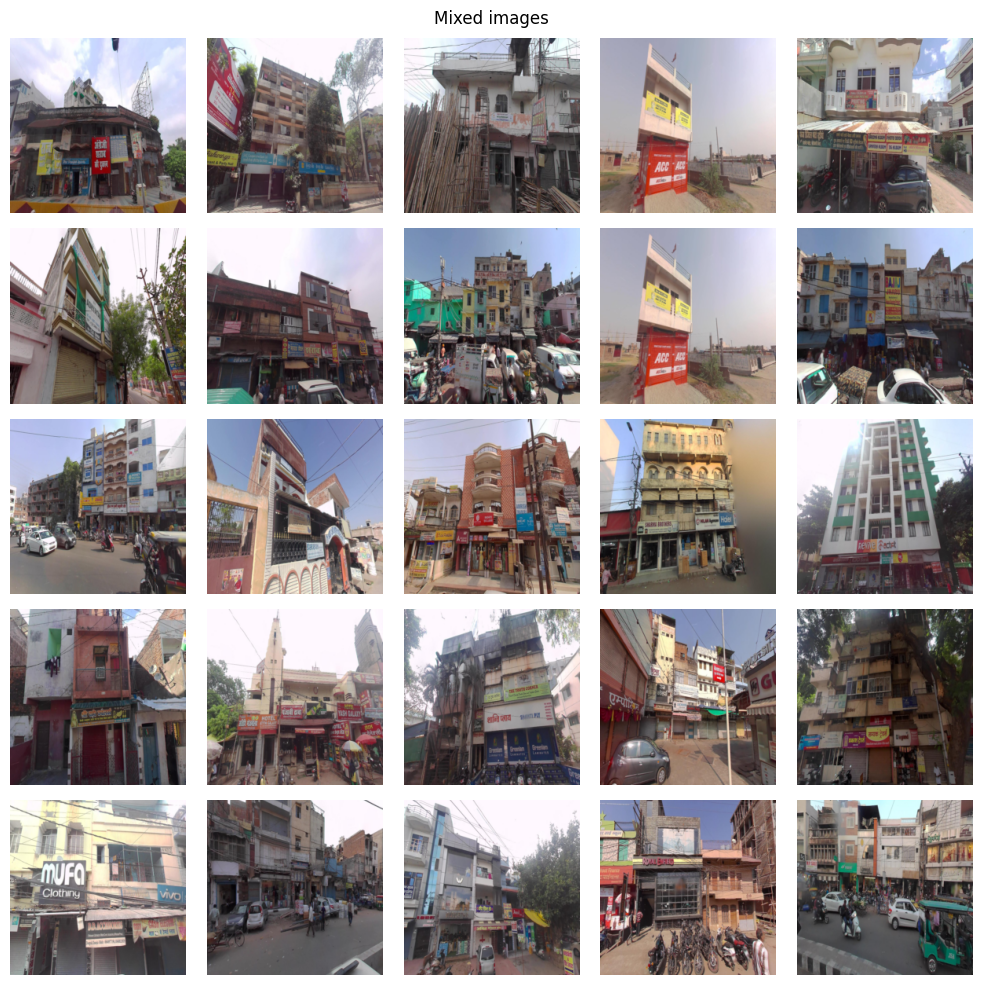

In [113]:
import random
def visualize_samples(dataset,title):
    
    fig, ax= plt.subplots(nrows=5, ncols=5, figsize=[10,10])
    fig.suptitle(title)

    for i,axi in enumerate(ax.flat):
        idx=random.randint(0,len(dataset)-1)
        img= dataset[idx]

        # print(img)
        axi.imshow(transforms.ToPILImage()(img))
        axi.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(mixed_type_dataset, 'Mixed images')

## Inferencing the composition using PCA

### Loading the model

In [114]:
model_final_ga= copy.deepcopy(model_test)

In [115]:
model_final_ga.to(device)
pass

The final model after genetic algorithm is model_final_ga

### Getting the classwise representation and plotting the classwise centroids

In [117]:
classwise_rpns= get_classwise_representations(model_final_ga, single_loader, device)

for label, rpns in classwise_rpns.items():
    classwise_rpns[label]= np.concatenate(rpns, axis= 0)
    
np.save('classwise_rpns_ga.npy', classwise_rpns)


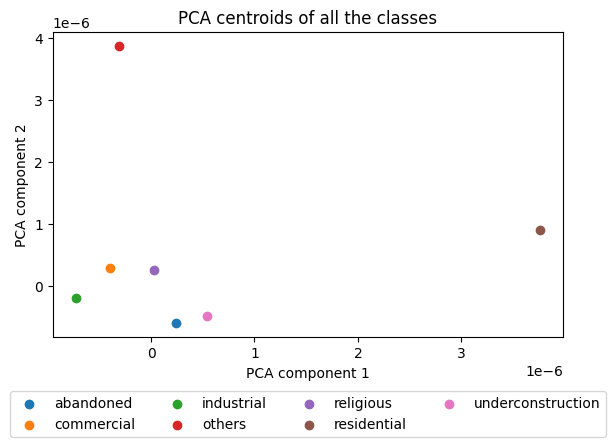

In [153]:
centroids_pca= create_pca_scatter(classwise_rpns, building_labels)

In [170]:
centroids_pca

array([[ 2.4411196e-07, -5.9687233e-07],
       [-3.9359475e-07,  2.9337295e-07],
       [-7.2664517e-07, -1.8592442e-07],
       [-3.0704629e-07,  3.8737599e-06],
       [ 2.5053076e-08,  2.6322661e-07],
       [ 3.7594123e-06,  9.1172626e-07],
       [ 5.3716661e-07, -4.7313853e-07]], dtype=float32)

In [122]:
np.save('centroids_pca.npy', centroids_pca)

## Getting the percentage composition per mixed-type image

In [123]:
def get_img_rpns(model, loader, device):

    model.eval()
    rpns=[]
    with torch.no_grad():
        
        for imgs in loader:
            imgs= imgs.to(device)
            output= model(imgs)
            rpn= output.logits.cpu().numpy()
            rpns.append(rpn)
            
    rpns=  np.concatenate(rpns, axis=0)
    return rpns

In [124]:
mixed_rpns= get_img_rpns(model_final_ga, mixed_loader, device)

In [125]:
len(mixed_rpns)

100

In [132]:
coords=[]
for rpn in mixed_rpns:
    pca= PCA(n_components= 2)
    coord= pca.fit_transform(np.reshape(rpn, (8,8)))
    coord= np.mean(coord, axis=0)
    coords.append(coord)


In [150]:
centroids_pca.values()

dict_values([array([ 2.8445754e-07, -5.7267550e-07], dtype=float32), array([-3.4521022e-07,  2.9095418e-07], dtype=float32), array([-6.9904161e-07, -1.8611621e-07], dtype=float32), array([-5.3757134e-07,  3.9624201e-06], dtype=float32), array([-7.203556e-09,  2.399087e-07], dtype=float32), array([3.6520482e-06, 7.8681546e-07], dtype=float32), array([ 5.5422089e-07, -5.1925963e-07], dtype=float32)])

In [154]:
coords= np.asarray(coords)
temp=[]
for value in centroids_pca.values():
    temp.append(value)
centroids_pca= np.asarray(temp)

In [156]:

distances = np.linalg.norm(coords[:, np.newaxis, :] - centroids_pca, axis=2)

total_sum = np.sum(distances, axis=1)

percentage_composition = distances / total_sum[:, np.newaxis]


In [174]:
percentage_composition

array([[0.06002834, 0.04661248, 0.07040389, 0.36633343, 0.02557753,
        0.3641518 , 0.06689257],
       [0.06191743, 0.04468578, 0.06945639, 0.3651373 , 0.02437913,
        0.3654949 , 0.06892905],
       [0.0612303 , 0.04508049, 0.06922729, 0.36558113, 0.02505506,
        0.36540326, 0.06842252],
       [0.06546542, 0.04471288, 0.0738067 , 0.3625571 , 0.01964417,
        0.36346945, 0.07034434],
       [0.05777695, 0.04937797, 0.07242446, 0.36765805, 0.02685092,
        0.3618369 , 0.06407477],
       [0.06453071, 0.04491304, 0.07308429, 0.363259  , 0.02070148,
        0.363727  , 0.06978453],
       [0.06255607, 0.04567651, 0.07200795, 0.36465222, 0.02279104,
        0.3638693 , 0.06844699],
       [0.05408885, 0.05129507, 0.07104872, 0.36984974, 0.03057092,
        0.36154854, 0.06159818],
       [0.05985907, 0.04588564, 0.06878576, 0.3664442 , 0.02640374,
        0.36520165, 0.0674199 ],
       [0.05933823, 0.04700739, 0.07018908, 0.36676633, 0.02625663,
        0.36405492, 0.0

In [ ]:
centroids_pca= create_pca_scatter(classwise_rpns, building_labels)

# FINAL RESULT

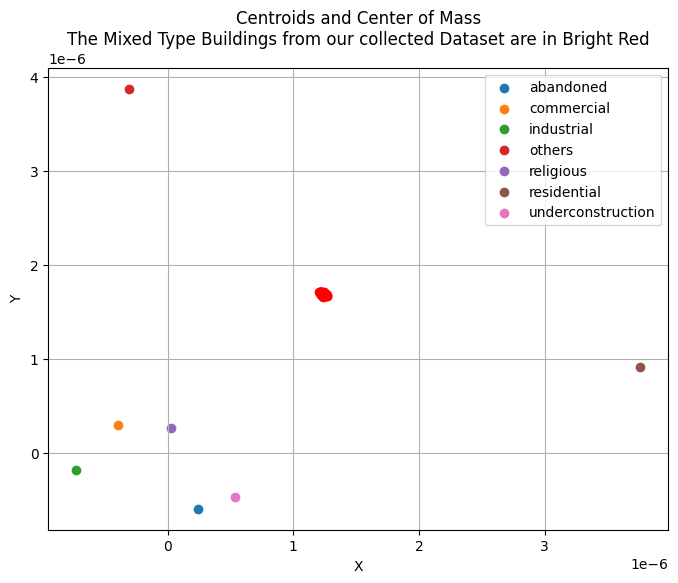

In [178]:
def center_of_mass(points, weights):
    
    # Calculate center of mass of weighted x and weighted y:
    weighted_sum_x = np.sum(points[:, 0] * weights)
    weighted_sum_y = np.sum(points[:, 1] * weights)

    total_weight = np.sum(weights)
    
    center_x = weighted_sum_x / total_weight
    center_y = weighted_sum_y / total_weight
    
    return center_x, center_y

plt.figure(figsize=(8, 6))
for idx,point in enumerate(centroids_pca):
    plt.scatter(point[0], point[1], label=building_labels[idx])

for i in range(percentage_composition.shape[0]):
    center_x, center_y = center_of_mass(centroids_pca, percentage_composition[i])
    plt.scatter(center_x, center_y, color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Centroids and Center of Mass\nThe Mixed Type Buildings from our collected Dataset are in Bright Red')
plt.grid(True)
plt.show()

In [171]:
# Normalize each array
normalized_arr = np.zeros_like(arr)
for i in range(len(arr)):
    total = np.sum(arr[i])  
    normalized_arr[i] = arr[i] / total  
    normalized_arr[i] *= total  

print(normalized_arr)

[-0.02550948  0.03288512  0.03288512 ... -0.02550948  0.03288512
 -0.02550948]


In [162]:
building_labels

['abandoned',
 'commercial',
 'industrial',
 'others',
 'religious',
 'residential',
 'underconstruction']